# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re

# Helper

In [2]:
def scrapeInfo(fp):
    with open(fp, 'r+') as f:
        content = f.read()
        lines = content.split('\n')
        time = lines[-2]
        if "Time taken Cooley Turkey FFT: " in time:
            time = re.sub("Time taken Cooley Turkey FFT: ", "", time)
        if "Time taken Naive FFT: " in time:
            time = re.sub("Time taken Naive FFT: ", "", time)
        if "Time taken Convolution: " in time:
            time = re.sub("Time taken Convolution: ", "", time)
        
        time = re.sub(" us", "", time)
        time = float(time)
        psnr = float(re.sub("PSNR: ", "", lines[-1]))
        return [time, psnr]

# Info Loading

In [3]:
os.system("rm ./experiments/.DS_Store")
exp_dir = "./experiments"
exp_dirs = sorted(os.listdir(exp_dir))
print("Num experiments: ", len(exp_dirs))
print("ex exp:", exp_dirs[0])

Num experiments:  99
ex exp: conv_128_11_0.5


In [4]:
test_path = "./experiments/conv_32_5_0.5/logging.txt"
print(test_path)
print(scrapeInfo(test_path))

./experiments/conv_32_5_0.5/logging.txt
[375.0, 26.145951016039206]


In [5]:
# get uniques
# convs
c_kernel = []
c_size = []
c_sigma = []

# dft
d_r = []
d_size = []

# fft
f_r = []
f_size = []

# group exps
for exp in exp_dirs:
    args = exp.split('_')
    if args[0] == 'conv':
        c_size.append(int(args[1]))
        c_kernel.append(int(args[2]))
        c_sigma.append(float(args[3]))
    if args[0] == 'dft':
        d_size.append(int(args[1]))
        d_r.append(float(args[2]))
    if args[0] == 'fft':
        f_size.append(int(args[1]))
        f_r.append(float(args[2]))

c_kernel = sorted(np.unique(c_kernel))
c_size = sorted(np.unique(c_size))
c_sigma = sorted(np.unique(c_sigma))
d_r = sorted(np.unique(d_r))
d_size = sorted(np.unique(d_size))
f_r = sorted(np.unique(f_r))
f_size = sorted(np.unique(f_size))

print("unique conv size:", c_size)
print("unique conv kernels:", c_kernel)
print("unique conv sigmas:", c_sigma)
print("unique dft size:", d_size)
print("unique dft r:", f_r)
print("unique fft size:", f_size)
print("unique fft r:", f_r)

unique conv size: [32, 64, 128, 256, 512]
unique conv kernels: [3, 5, 7, 9, 11]
unique conv sigmas: [0.5, 0.85, 1.25]
unique dft size: [32, 64, 128]
unique dft r: [0.3, 1.0, 3.0]
unique fft size: [32, 64, 128, 256, 512]
unique fft r: [0.3, 1.0, 3.0]


In [6]:
# generate dicts
convs = {s :{ k:{ sig: None for sig in c_sigma} for k in c_kernel} for s in c_size}
dfts = {s : { r: None for r in d_r} for s in d_size}
ffts = {s : { r: None for r in f_r} for s in f_size}

# Population

In [7]:
# group exps
for exp in exp_dirs:
    args = exp.split('_')
    path = os.path.join(exp_dir, exp)
    file = os.path.join(path, 'logging.txt')
    if args[0] == 'conv':
        convs[int(args[1])][int(args[2])][float(args[3])] = scrapeInfo(file)
    if args[0] == 'dft':
        dfts[int(args[1])][float(args[2])] = scrapeInfo(file)
    if args[0] == 'fft':
        ffts[int(args[1])][float(args[2])] = scrapeInfo(file)

# Plots

## Time vs Size

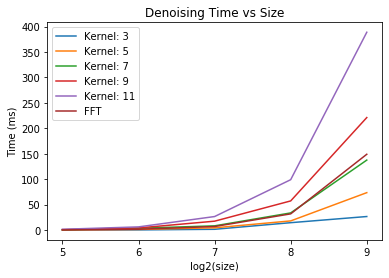

In [8]:
# Time plots
legend = []
# convs
for kernel in c_kernel:
    y = []
    x = []
    for size in c_size:
        y.append(convs[size][kernel][c_sigma[0]][0] / 1e3)
        x.append(size)
    legend.append("Kernel: " + str(kernel))
    plt.plot(np.log2(x), y)

# fft
y = []
x = []
for size in c_size:
    y.append(ffts[size][f_r[0]][0] / 1e3)
    x.append(size)
legend.append("FFT")
plt.plot(np.log2(x), y, color='brown')
plt.legend(legend)
plt.title("Denoising Time vs Size")
plt.xticks(np.arange(5,10))
plt.xlabel("log2(size)")
plt.ylabel("Time (ms)")
plt.show()

## PSNR vs Kernel Size

In [9]:
psnr = 0
sigma = 0
kern = 0
for size in c_size:
    psnr = 0
    sigma = 0
    for kernel in c_kernel:
        for sig in c_sigma:
            if convs[size][kernel][sig][1] > psnr:
                psnr = convs[size][kernel][sig][1]
                sigma = sig
                kern = kernel
                
    print("Best PSNR at size "+str(size)+" is "+str(psnr)+" at sigma "+str(sigma)+" with kernel "+str(kern))        

Best PSNR at size 32 is 26.145951016039206 at sigma 0.5 with kernel 5
Best PSNR at size 64 is 27.29614660269283 at sigma 0.5 with kernel 3
Best PSNR at size 128 is 28.489909744226548 at sigma 0.5 with kernel 11
Best PSNR at size 256 is 30.753291196628464 at sigma 0.85 with kernel 3
Best PSNR at size 512 is 32.463209718892585 at sigma 0.85 with kernel 5


# Best FFT PSNR

In [10]:
psnr = 0
r = 0
for size in f_size:
    psnr = 0
    r = 0
    for rr in f_r:
        if ffts[size][rr][1] > psnr:
            psnr = ffts[size][rr][1]
            r = rr
                
    print("Best PSNR at size "+str(size)+" is "+str(psnr)+" at r "+str(r))
            

Best PSNR at size 32 is 26.676678522062854 at r 0.3
Best PSNR at size 64 is 27.198177482238705 at r 0.3
Best PSNR at size 128 is 28.430769089006887 at r 1.0
Best PSNR at size 256 is 30.20171233653806 at r 1.0
Best PSNR at size 512 is 32.224122688846506 at r 3.0
